In [262]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 2048 Environment implementation

from https://github.com/moporgic/2048-Demo-Python/

In [250]:
import random

class board:
    """simple implementation of 2048 puzzle"""
    
    def __init__(self, tile = None):
        self.tile = tile if tile is not None else [0] * 16
    
    def __str__(self):
        state = '+' + '-' * 24 + '+\n'
        for row in [self.tile[r:r + 4] for r in range(0, 16, 4)]:
            state += ('|' + ''.join('{0:6d}'.format((1 << t) & -2) for t in row) + '|\n')
        state += '+' + '-' * 24 + '+'
        return state
    
    def mirror(self):
        return board([self.tile[r + i] for r in range(0, 16, 4) for i in reversed(range(4))])
    
    def transpose(self):
        return board([self.tile[r + i] for i in range(4) for r in range(0, 16, 4)])
    
    def rotate(self):
        return board([self.tile[4*(3-(i%4)) + (i//4)] for i in range(16)])
    
    def left(self):
        move, score = [], 0
        for row in [self.tile[r:r+4] for r in range(0, 16, 4)]:
            row, buf = [], [t for t in row if t]
            while buf:
                if len(buf) >= 2 and buf[0] is buf[1]:
                    buf = buf[1:]
                    buf[0] += 1
                    score += 1 << buf[0]
                row += [buf[0]]
                buf = buf[1:]
            move += row + [0] * (4 - len(row))
        return board(move), score if move != self.tile else -1
    
    def right(self):
        move, score = self.mirror().left()
        return move.mirror(), score
    
    def up(self):
        move, score = self.transpose().left()
        return move.transpose(), score
    
    def down(self):
        move, score = self.transpose().right()
        return move.transpose(), score
    
    def popup(self):
        tile = self.tile[:]
        empty = [i for i, t in enumerate(tile) if not t]
        tile[random.choice(empty)] = random.choice([1] * 9 + [2])
        return board(tile)
    
    def end(self):
        tile = self.tile[:]
        empty = [i for i, t in enumerate(tile) if not t]
        return len(empty) == 0

In [353]:
def gamestatus(game, maxnum=12):
    counter = [0]*maxnum
    for i in game.tile:
        counter[i]+=1
    return np.array(counter) / len(game.tile)

def showstatus(game):
    s = ""
    for i, p in enumerate(gamestatus(game)):
        s += "{:4d}:[{:3.1f}] ".format(1<<i & -2, p*100.0)
    return s

# n-Tuples Pattern

In [372]:
def find_isomorphic_pattern(pattern):
    a = board(list(range(16)))

    isomorphic_pattern = []
    for i in range(8):
        if (i >= 4):
            b = board( a.mirror().tile )
        else:
            b = board( a.tile )
        for _ in range(i%4):
            b = b.rotate()
        isomorphic_pattern.append(np.array(b.tile)[pattern])
        
    return isomorphic_pattern

class TuplesNet():
    def __init__(self, pattern, maxnum):
        self.V = np.zeros(([maxnum]*len(pattern)))
        self.pattern = pattern
        self.isomorphic_pattern = find_isomorphic_pattern(self.pattern)
        
    def getState(self, tile):
        return [tuple(np.array(tile)[p]) for p in self.isomorphic_pattern]
    
    def getValue(self, tile):
        S = self.getState(tile)
        
        V = [self.V[s] for s in S]
        
        # sum all value from isomorphic pattern
        V = sum(V)
        #V = sum(V) / len(V)
        
        return V
    
    def setValue(self, tile, v, reset=False):
        S = self.getState(tile)
        
        # set value to isomorphic pattern
        v /= len(self.isomorphic_pattern)
        V = 0.0
        for s in S:
            self.V[s] += v
            #if not reset:
                #self.V[s] += v
            #else:
                #self.V[s] =  v
                
            V += self.V[s]
        return V

# TD learning

In [403]:
# my implement ref from pseudo algo
            # game__ = board(s__)
            # next_games__ = [game__.up(), game__.down(), game__.left(), game__.right()]
            # action = np.argmax(self.evaulate(next_games__))
            
            # next_game__, reward__ = next_games__[action]
            
            # V(s') = V(s') + \alpha ( r_next + V(s'_next) - V(s') )
            # v =  reward__ + self.getValue(next_game__.tile) - self.getValue(s_)
            # self.setValue(s_, lr * v)

In [404]:
class Agent():
    def __init__(self, patterns, maxnum):
        self.Tuples = []
        for p in patterns:
            self.Tuples.append(TuplesNet(p, maxnum))
        self.metrics = []
        
    def getValue(self, tile):
        V = [t.getValue(tile) for t in self.Tuples]
        
        # get average
        V = sum(V)
        #V = sum(V) / len(V)
        
        return V
    
    def setValue(self, tile, v, reset=False):
        v /= len(self.Tuples)
        V = 0.0
        for t in self.Tuples:
            V += t.setValue(tile, v, reset)
        return V
    
    # get all s'
    def evaulate(self, next_games):
        # TD(0)-after
        #  r + V(s')
        return [ng[1] + self.getValue(ng[0].tile) for ng in next_games]
    
    def learn(self, records, lr):
        
        exact = 0.0
        
        # exact = records[0][2]
        # records[0:] ignore terminate, s' can't be s''
        
        # learn from end to begin
        # records = [end .... begin]
        # (s, a, r, s', s'')
        for s, a, r, s_, s__ in records: 
            # TD(0)-after
            
            # V(s') = V(s') + \alpha ( r_next + V(s'_next) - V(s') )
            error = exact - self.getValue(s_)
            exact = r + self.setValue(s_, lr*error)
            
            # from c++ impelement
            # V(s') = V(s) - r ?
            # error = exact - (self.getValue(s) - r)
            # exact = r + self.setValue(s_, lr*error)
            
    def showStattistic(self, epoch, unit):
        metrics = np.array(self.metrics[-unit:])
        
        # get average score
        score_mean = np.mean(metrics[:, 0])
        # get max score
        score_max = np.max(metrics[:, 0])
        
        print('{:<8d}mean = {:<8.0f} max = {:<8.0f}'.format(epoch, score_mean, score_max))
        
        if (metrics.shape[1] < 3):
            return
        
        # all end game board
        end_games = metrics[:, 2]
        
        reach_nums = np.array([1<<max(end) & -2 for end in end_games])
                  
        print('\n')    
        
        for num in np.sort(np.unique(reach_nums)):
            # count how many game over this num
            reachs = np.count_nonzero(reach_nums >= num)
            
            # count how many game end at this num
            ends = np.count_nonzero(reach_nums == num)
            
            print('{:<5d}  {:3.1f} % ({:3.1f} %)'.format(num, (reachs*100)/len(metrics), (ends*100)/len(metrics)))
        
        return
    
    def train(self, epoch_size, lr=0.1, showsize=1000):
        start_epoch = len(self.metrics)
        for epoch in range(start_epoch, epoch_size):
            # init score and env (2048)
            score = 0.0
            game = board().popup().popup()
            records = []
            while True:
                # choose action
                next_games = [game.up(), game.down(), game.left(), game.right()]
                action = np.argmax(self.evaulate(next_games))
                
                # do action
                # s'
                next_game, reward = next_games[action]
                
                # save record (s, a, r, s')
                # records.insert(0, (game.tile, action, reward, next_game.tile) )
                
                # game is same as before, end game
                #if reward == -1:
                if game.end():
                    break
                
                # s''
                next_game_after = next_game.popup()
                
                score += reward
                
                # save record (s, a, r, s', s'')
                records.insert(0, (game.tile, action, reward, next_game.tile, next_game_after.tile) )
                # records.insert(0, (game.tile, action, score, next_game.tile, next_game_after.tile) )
                
                # s = s'' update state
                game = next_game_after
                
            #self.learn(records, lr / len(self.Tuples))
            self.learn(records, lr)
            
            # store score, game len, end game board
            self.metrics.append( (score, len(records), game.tile) )
            if (epoch+1) % showsize == 0:
                self.showStattistic(epoch+1, showsize)
            #if True:
                #print('[{:6d}] l : {:2d}, score : {:4.0f}, status : {}'.format(epoch, len(records), score, showstatus(game)))
            clear_output(wait=True)

In [405]:
MAX_NUM = 12 # 1<<12 == 4096
TUPLE_NUM = 6 # 6-tuples
PATTERN_NUM = 4
ACTION_NUM = 4 # up, down, left, right

PATTERNS = [
    [0,1,2,3,4,5],
    [4,5,6,7,8,9],
    [0,1,2,4,5,6],
    [4,5,6,8,9,10]
]

In [417]:
random.seed(756110)
agent = Agent(PATTERNS, MAX_NUM)

In [ ]:
%%time
agent.train(10000)

In [419]:
agent.showStattistic(999, 1000)

999     mean = 4058     max = 16498   


32     100.0 % (0.4 %)
64     99.6 % (5.0 %)
128    94.6 % (20.8 %)
256    73.8 % (41.8 %)
512    32.0 % (29.7 %)
1024   2.3 % (2.3 %)


In [322]:
def showCurve(metrics):
    metrics = np.array(metrics).reshape(len(metrics), -1)

    plt.figure(figsize=(12,4))
    plt.plot(metrics[:,0], label='score')

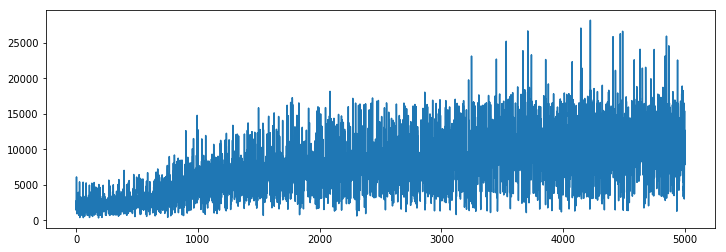

In [347]:
showCurve(agent.metrics)

In [ ]:
def saveAgent(agent, fileName):
    with open(fileName, 'wb') as f:
        pickle.dump(agent, f)
    return fileName
    
def loadAgent(fileName):
    with open(fileName, 'rb') as f:
        agent = pickle.load(f)
    return agent